# Compute Architecure - Assessment
**Course**: TU 2025 25-26: 8645 -- COMPUTER INFRASTRUCTURE  
**Lecturer**: Ian McLauglin  
**Author**: Clyde Watts  








### Imports

yfinance - financial ticker data from yahoo  - [yfinance](https://github.com/ranaroussi/yfinance)
datetime - pythons inbuild date time
logging - python logging
os - operating system functions
glob - file selector

In [15]:

import logging
from datetime import datetime, timedelta
import os
import pathlib as Path
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf

##  Initialisation

In [47]:
# init logging
logging.basicConfig(level=logging.INFO)

In [48]:
# Delete all CSV files in the data directory
data_path = "./data/"
files = glob.glob(os.path.join(data_path, "*.csv"))
for f in files:
    print(f"Deleting file: {f}")
    os.remove(f)

Deleting file: ./data\20251109_155644.csv


### Helper Functions 




__Function: print_status__

Prints the status with a green tick or red cross. This makes it easier to validate function return codes

In [74]:





def print_status(return_code, description, return_message):
    """
    Print status with visual indicator
    
    Args:
        return_code (int): 0 for success, non-zero for failure
        description (str): Status description
        return_message (str): Related file name
    """
    if return_code == 0:
        # Green tick for success (bold)
        status_symbol = "\033[1;92m✓\033[0m"  # Bold green checkmark
    else:
        # Red X for failure (bold)
        status_symbol = "\033[1;91m✗\033[0m"  # Bold red X

    # Print entire line in bold
    print(f"\033[1m{status_symbol} Status: {return_code}, Message: {description}, File: {return_message}\033[0m")


__Smoke Test__

In [73]:
print("Smoke Test Results:")
print_status(0, "Latest file retrieval", "file_name.csv")
print_status(1, "File retrieval failed", "file_name.csv")

Smoke Test Results:
✓ Status: 0, Message: Latest file retrieval, File: file_name.csv
✗ Status: 1, Message: File retrieval failed, File: file_name.csv


## Problem 1: Data from yfinance

Using the [yfinance](https://github.com/ranaroussi/yfinance) Python package, write a function called `get_data()` that downloads all hourly data for the previous five days for the five FAANG stocks:

- Facebook (META)
- Apple (AAPL)
- Amazon (AMZN)
- Netflix (NFLX)
- Google (GOOG)

The function should save the data into a folder called `data` in the root of your repository using a filename with the format `YYYYMMDD-HHmmss.csv` where `YYYYMMDD` is the four-digit year (e.g. 2025), followed by the two-digit month (e.g. `09` for September), followed by the two digit day, and `HHmmss` is hour, minutes, seconds.
Create the `data` folder if you don't already have one.

## Problem 1: Requirements ##

### Extract ###

1.  Extract from yfinance data the stock data for META,AAPL,AMZN,NFLX,GOOG
2.  For 5 complete previous days trading , we need to take into account that NASDAQ trades from Monday to Friday. If we go back 7 days we will always ignore weekends
3.  File format will YYYYMMDD-HHmmss.csv where YYYY - is 4 digit year , MM month 01-12 , DD - is 01-31. HH - hours , 24 our clock , mm - minutes 00-59 , seconds 00-59.
4.  Grain - Hour

Column
Date , <ticket> ( Open,High,Low,Close,Volume) ....
ticket is META , AAPL , AMZN , NFLX or GOOG
Open - open price
Close - close price
High - High pricr
Low - Low price
Volumn - Volume in period

The data frame return has an index on the date , and is a multilevel index. Level one is the ticket , and the second level is the metric - that is open , close , high , low prices and volume 
 

Todo:

1. Take Into account non-trading days as well as weekends - considered over engineering
1. Add a time column with EST instead of UCT.

__Function : get_data__

This downloads the latest data for a number of listed stock companies using yfinance module and writes to CSV file. 

In [75]:
# prototype for extracting stock data
tickers = ["META", "AAPL", "AMZN", "NFLX", "GOOG"]
def get_data(tickers = tickers,start_date=None, end_date=None,interval="1h",data_path="./data/"):
    """
    Function to get stock data from yfinance

    Parameters:
    tickers (list): List of stock tickers to download data for
    start_date (str): Start date for data in format "YYYY-MM-DD". If None, defaults to 6 days ago.
    end_date (str): End date for data in format "YYYY-MM-DD". If None, defaults to yesterday.
    interval (str): Data interval. Default is "1h".
    data_path (str): Path to save the data. Default is "./data/".
    Returns:
       return_code : 0 for success, -1 for failure
       return_message : message indicating success or failure
       file_name (str): Name of the file where data is saved
    """
    return_code = 0
    return_message = "Success"
    file_name = None
    if start_date is None:
        # Variation of the fence posting to get last 7 days of data
        start_date = (datetime.now() - timedelta(days=7)).strftime("%Y-%m-%d")
        # create file name based on current date and time
        file_name = f"{data_path}{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    else:
        # convert start_date to datetime object
        start_date_time = datetime.strptime(start_date, "%Y-%m-%d")
        # create file name based on start time and 23:59:59 of end date
        start_date_str = start_date_time.strftime("%Y%m%d") + "_235959"
        file_name = f"{data_path}{start_date_str}.csv"
    # if end_date is None , set to today - 0 days this means yesterday's data inclusive
    if end_date is None:
        end_date = (datetime.now() - timedelta(days=0)).strftime("%Y-%m-%d")
    else: # convert end_date to datetime object
        end_date_time = datetime.strptime(end_date, "%Y-%m-%d")
        # add 1 day to end_date to make it inclusive
        end_date = (end_date_time + timedelta(days=1)).strftime("%Y-%m-%d")
    # check if directory exists
    if not os.path.exists(data_path):
        logging.info(f"Creating directory: {data_path}")
        try:
            os.makedirs(data_path)
        except Exception as e:
            logging.error(f"Error creating directory: {e}")
            return_code = -1
            return_message = f"Error creating directory: {e}"
            return return_code, return_message, None
    # if file exists then delete it
    if os.path.exists(file_name):
        logging.info(f"Deleting existing file: {file_name}")
        try:
            os.remove(file_name)
        except Exception as e:
            logging.error(f"Error deleting file: {e}")
            return_code = -1
            return_message = f"Error deleting file: {e}"
            return return_code, return_message, None
    logging.info(f"Start Date: {start_date}, End Date: {end_date}")
    try:
        df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date)
    except Exception as e:
        logging.error(f"Error downloading data: {e}")
        return_code = -1
        return_message = f"Error downloading data: {e}"
        return return_code, return_message, None
    # Save the data to a CSV file
    df_data.to_csv(file_name)
    return return_code, return_message, file_name
   



In [76]:
print("Starting data download...")
return_code, return_message, file_name = get_data(tickers=tickers)
print_status(return_code, return_message, file_name)
df_data = get_data(tickers=tickers) 

INFO:root:Start Date: 2025-11-02, End Date: 2025-11-09
C:\Users\cw171001\AppData\Local\Temp\ipykernel_58508\3298150898.py:61: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date)
[                       0%                       ]C:\Users\cw171001\AppData\Local\Temp\ipykernel_58508\3298150898.py:61: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed
INFO:root:Deleting existing file: ./data/20251109_162117.csv
INFO:root:Start Date: 2025-11-02, End Date: 2025-11-09

INFO:root:Deleting existing file: ./data/20251109_162117.csv
INFO:root:Start Date: 2025-11-02, End Date: 2025-11-09
C:\Users\cw171001\AppData\Local\Temp\ipykernel_58508\3298150898.py:61: FutureWarning: YF.do

Starting data download...
✓ Status: 0, Message: Success, File: ./data/20251109_162117.csv


[*********************100%***********************]  5 of 5 completed



## Problem 2: Plotting Data

Write a function called `plot_data()` that opens the latest data file in the `data` folder and, on one plot, plots the `Close` prices for each of the five stocks.
The plot should include axis labels, a legend, and the date as a title.
The function should save the plot into a `plots` folder in the root of your repository using a filename in the format `YYYYMMDD-HHmmss.png`.
Create the `plots` folder if you don't already have one.


### Assignment: Problem 2 Requirements Specification

Here is a checklist of all the tasks the `plot_data()` function must accomplish:

**1. File Input & Data Loading**
* [✅] Access the `data` folder.
* [✅] Identify the *latest* file in the `data` folder (e.g., by checking file modification time or finding the most recent date in the filename).
* [✅] Open and read the data from this file (assuming it's a format like CSV, likely using `pandas`).

**2. Data Processing**
* [✅] Extract the `Close` price columns for all five stocks.
* [ ] Ensure the corresponding date/time data is available to be used for the x-axis.

**3. Plot Generation & Styling**
* [✅] Create a *single* plot figure.
* [✅] Plot all five `Close` price series as lines on this single plot.
* [ x] Set a clear label for the x-axis (e.g., "Date").
* [ x] Set a clear label for the y-axis (e.g., "Closing Price ($)").
* [✅] Add a legend that correctly identifies each of the five stocks.
* [✅] Get the *current* date and time.
* [✅] Set the plot's title to the current date (e.g., "Stock Prices as of YYYY-MM-DD").

**4. File Output**
* [✅] Check if a folder named `plots` exists in the root directory.
* [✅] If the `plots` folder does not exist, create it.
* [✅] Generate a filename based on the current date and time in `YYYYMMDD-HHmmss` format (e.g., `20251109-161120`).
* [✅] Save the generated plot to the `plots` folder using the generated filename with a `.png` extension.
* [✅] Ensure the plot is closed after saving to free up resources.

This list should cover everything. The next logical step would be to think about the libraries we'll need—probably `os` (to find files and create folders), `pandas` (to read the data), and `matplotlib` (to make the plot).

Let me know when you're ready to start writing the Python code for it!

https://docs.python.org/3/library/glob.html

Note: Gemini was used to generate the check list . This was not used to use agentic ai to generate the code. 
- [x] Completed task
- [ ] Incomplete task✓ Success
✔ Done
✅ Completed
- [x] Task finished

__Function: print_status__

This prints the status. 

Clear Down Data before test

__Function : get_the_latest_file__

This scans directory ./data ( parameter ) using a pattern 20....csv to get the latest file and returns the file name

In [77]:
#------------------------------------------------------------------------------
# Function to get the latest file from a directory
#------------------------------------------------------------------------------

def get_latest_file(data_path="./data/"):
    """
    Returns the path to the latest data file in the specified directory.

    Args:
        data_path (str): The path to the directory containing the data files.

        tuple: (return_code, return_message, latest_file) where latest_file is the path to the latest data file, or None if no files are found.
        str: The path to the latest data file, or None if no files are found.
    """
    return_code = 0
    return_message = "Success"
    latest_file = None

    logging.info(f"Getting the latest file from {data_path}")
    # File pattern
    file_pattern = "20[0-9][0-9][0-1][0-9][0-3][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9].csv"
    # Add path to file pattern
    file_pattern = os.path.join(data_path, file_pattern)
    # glob searches directories for files based on a pattern
    try:
        list_of_files = glob.glob(file_pattern)
    except Exception as e:
        logging.error(f"Error occurred while searching for files: {e}")
        return_code=-1
        return_message=f"Error occurred while searching for files: {e}"
        return return_code, return_message, None
    if not list_of_files:
        logging.warning(f"No files found in {data_path} matching pattern {file_pattern}")
        return_code = -1
        return_message = f"No files found in {data_path} matching pattern {file_pattern}"
        return return_code, return_message, None
    # find the latest file based on creation time
    #    max parameters - list and function which gets "value" associated with each item in the list
    #    this gets the "youngest" file based on creation time 
    #    not necessarily the latest date in the file name - design decision 
    #    the premise is that the latest file created is the one we want to use
    latest_file = max(list_of_files, key=os.path.getctime)
    logging.info(f"Latest file: {latest_file}")
    return return_code, return_message, latest_file

__Function: get_PNG_filename_from_CSV_filename__

In [78]:
def get_PNG_filename_from_CSV_filename(csv_filename,plot_path="./plots/"):
    """
    Function to get PNG filename from CSV filename

    Parameters:
    csv_filename (str): Name of the CSV file
    plot_path (str): Path to save the PNG file. Default is "./plots/".

    Returns:
       png_filename (str): Name of the PNG file
    """
    return_code = 0
    return_message = "Success"
    # extract base name from csv_filename
    base_name = os.path.basename(csv_filename)
    # remove .csv extension
    base_name = os.path.splitext(base_name)[0]
    # create png filename
    png_filename = f"{plot_path}{base_name}.png"
    return return_code, return_message, png_filename

### Load data from 

In [82]:
return_code, return_message, file_name = get_latest_file()
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {file_name}", return_message)
# now get png file name from csv file name
return_code, return_message, png_file_path = get_PNG_filename_from_CSV_filename(file_name, "./plots/")
print_status(return_code, f"PNG file path retrieval - Return Code: {return_code}, Message: {return_message}, File: {png_file_path}", return_message)


INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251109_162117.csv
INFO:root:Latest file: ./data\20251109_162117.csv


✓ Status: 0, Message: Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251109_162117.csv, File: Success
✓ Status: 0, Message: PNG file path retrieval - Return Code: 0, Message: Success, File: ./plots/20251109_162117.png, File: Success


__Function : load_file_into_dataframe__

This loads the file name into data frame

In [83]:
def load_file_into_dataframe(file):
    """load_file_into_dataframe

    Args:
        file (str): The path to the data file.

    Returns:
        tuple: (return_code, return_message, df) where:
            return_code (int): 0 for success, -1 for failure
            return_message (str): Success or error message
            df (pd.DataFrame): The data as a pandas DataFrame with multi-level columns
    """
    return_code = 0
    return_message = "Success"
    df = None
    
    # Check if file name is provided
    if file is None:
        logging.error("No file provided to load into dataframe.")
        return_code = -1
        return_message = "No file provided to load into dataframe."
        return return_code, return_message, None
    
    # Check if file exists
    if not os.path.exists(file):
        logging.error(f"File does not exist: {file}")
        return_code = -1
        return_message = f"File does not exist: {file}"
        return return_code, return_message, None
    
    # Load the CSV file into a DataFrame with multi-level columns
    try:
        df = pd.read_csv(file, header=[0,1], index_col=0, parse_dates=True)
        logging.info(f"Successfully loaded data from {file}. Shape: {df.shape}")
    except Exception as e:
        logging.error(f"Error loading file {file}: {e}")
        return_code = -1
        return_message = f"Error loading file {file}: {e}"
        return return_code, return_message, None
    
    return return_code, return_message, df



In [84]:
print("Loading data from the latest file...")
return_code, return_message, latest_file = get_latest_file()
full_file_name = os.path.abspath(latest_file)
print(f"Loading data from file: {full_file_name}")
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

return_code, return_message, df = load_file_into_dataframe(latest_file)
print_status(return_code, f"File load - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

print(df.shape)
# convert csv file name to png file name
return_code, return_message, png_file_path = get_PNG_filename_from_CSV_filename(latest_file, "./plots/")
print(f"PNG file path: {png_file_path}")

INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251109_162117.csv
INFO:root:Latest file: ./data\20251109_162117.csv
INFO:root:Successfully loaded data from ./data\20251109_162117.csv. Shape: (35, 25)
INFO:root:Successfully loaded data from ./data\20251109_162117.csv. Shape: (35, 25)


Loading data from the latest file...
Loading data from file: c:\Users\cw171001\OneDrive - Teradata\Documents\GitHub\PFDA_computer_architecture\data\20251109_162117.csv
✓ Status: 0, Message: Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251109_162117.csv, File: Success
✓ Status: 0, Message: File load - Return Code: 0, Message: Success, File: ./data\20251109_162117.csv, File: Success
(35, 25)
PNG file path: ./plots/20251109_162117.png


### Investigate Data Frame

Have a look at the dataframe and see it's structure. 

https://ranaroussi.github.io/yfinance/reference/api/yfinance.download.html#yfinance.download

The index is DatetimeIndex - that is the timestamp of the price.
The data appears Company/Ticker - and then metrics - open,high,low,close,volume



In [107]:
# Have a look at the index and columns
print(" Data Frame Info")
print(df.info(verbose=True))

 Data Frame Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35 entries, 2025-11-03 14:30:00+00:00 to 2025-11-07 20:30:00+00:00
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (AAPL, Open)    35 non-null     float64
 1   (AAPL, High)    35 non-null     float64
 2   (AAPL, Low)     35 non-null     float64
 3   (AAPL, Close)   35 non-null     float64
 4   (AAPL, Volume)  35 non-null     int64  
 5   (META, Open)    35 non-null     float64
 6   (META, High)    35 non-null     float64
 7   (META, Low)     35 non-null     float64
 8   (META, Close)   35 non-null     float64
 9   (META, Volume)  35 non-null     int64  
 10  (AMZN, Open)    35 non-null     float64
 11  (AMZN, High)    35 non-null     float64
 12  (AMZN, Low)     35 non-null     float64
 13  (AMZN, Close)   35 non-null     float64
 14  (AMZN, Volume)  35 non-null     int64  
 15  (GOOG, Open)    35 non-null     float64
 16  (GOOG, High)   

Check the first and last dates . To check if the week is being covered.
That is the fense post problem

In [108]:
# Only get the datetime index and convert to a list
datetime_index = df.index.to_series().reset_index(drop=True)
# Convert series datetime to dates and remove duplicates and sort
date_list = datetime_index.dt.date.drop_duplicates().sort_values().astype(str)
print(date_list)

0     2025-11-03
7     2025-11-04
14    2025-11-05
21    2025-11-06
28    2025-11-07
Name: Datetime, dtype: object


Investigate the time zones , the data is from US NASDAQ - Monday to Friday 9:30 to 21:30 EST , UTC+8

https://www.ig.com/en/trading-strategies/nasdaq-opening-and-closing-times--when-can-you-trade--230527#:~:text=The%20index%20opens%20at%209.30,that's%204%20am%20UTC%2B8.&text=However%2C%20you%20can%20trade%20the,a%20day%2C%20Monday%20to%20Thursday.

In [109]:
# Only get the datetime index and convert to a list
datetime_index = df.index.to_series().reset_index(drop=True)
# Extract the time zone info
time_zone = datetime_index.dt.tz
print(f"Time Zone Info: {time_zone}")
# Extract time from datetime index
time_list = datetime_index.dt.time.drop_duplicates().sort_values().astype(str)
print("Time List:")
print(time_list)
# see if the convert the timezone to EST for NASDAQ data is possible
datetime_index_est = datetime_index.dt.tz_convert('US/Eastern')
print("Datetime Index in EST:")
time_list_est = datetime_index_est.dt.time.drop_duplicates().sort_values().astype(str)
print("Time List in EST:")
print(time_list_est)

Time Zone Info: UTC
Time List:
0    14:30:00
1    15:30:00
2    16:30:00
3    17:30:00
4    18:30:00
5    19:30:00
6    20:30:00
Name: Datetime, dtype: object
Datetime Index in EST:
Time List in EST:
0    09:30:00
1    10:30:00
2    11:30:00
3    12:30:00
4    13:30:00
5    14:30:00
6    15:30:00
Name: Datetime, dtype: object


In [110]:
print("Loading data from the latest file...")
return_code, return_message, latest_file = get_latest_file()
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

return_code, return_message, df = load_file_into_dataframe(latest_file)
print_status(return_code, f"File load - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

print(df.shape)
# convert csv file name to png file name
return_code, return_message, png_file_path = get_PNG_filename_from_CSV_filename(latest_file, "./plots/")
print(f"PNG file path: {png_file_path}")
return_code, return_message, df = load_file_into_dataframe(latest_file)
print(f"Function :  Return_Code = {return_code} Return Message = {return_message}")
data_path = "./data/"



INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251109_162117.csv
INFO:root:Successfully loaded data from ./data\20251109_162117.csv. Shape: (35, 25)
INFO:root:Successfully loaded data from ./data\20251109_162117.csv. Shape: (35, 25)


Loading data from the latest file...
✓ Status: 0, Message: Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251109_162117.csv, File: Success
✓ Status: 0, Message: File load - Return Code: 0, Message: Success, File: ./data\20251109_162117.csv, File: Success
(35, 25)
PNG file path: ./plots/20251109_162117.png
Function :  Return_Code = 0 Return Message = Success


In [111]:
df

Ticker                           AAPL                                      \
Price                            Open        High         Low       Close   
Datetime                                                                    
2025-11-03 14:30:00+00:00  270.420013  270.779999  266.250000  267.630005   
2025-11-03 15:30:00+00:00  267.640015  268.279999  266.500000  266.640015   
2025-11-03 16:30:00+00:00  266.659912  268.149994  266.522308  267.535004   
2025-11-03 17:30:00+00:00  267.519989  268.000000  267.250000  267.678009   
2025-11-03 18:30:00+00:00  267.709900  268.619995  267.309998  267.309998   
2025-11-03 19:30:00+00:00  267.320007  267.790009  266.910004  267.619995   
2025-11-03 20:30:00+00:00  267.630005  269.109985  267.459991  269.059998   
2025-11-04 14:30:00+00:00  268.242493  269.589996  267.614990  268.429993   
2025-11-04 15:30:00+00:00  268.429993  271.000000  267.709991  270.609985   
2025-11-04 16:30:00+00:00  270.640015  271.485992  268.980011  270.010010   
2025-11-04 17:30:00+00:00  270.005005  270.929993  269.890015  270.638397   
2025-11-04 18:30:00+00:00  270.609985  270.820007  269.869995  270.510406   
2025-11-04 19:30:00+00:00  270.529999  270.609985  269.282715  270.090515   
2025-11-04 20:30:00+00:00  270.100006  270.404999  269.500000  270.209991   
2025-11-05 14:30:00+00:00  268.589996  269.589905  266.929993  269.010101   
2025-11-05 15:30:00+00:00  268.989990  270.380005  268.760010  270.290009   
2025-11-05 16:30:00+00:00  270.279999  270.470001  269.500000  269.970001   
2025-11-05 17:30:00+00:00  269.970001  270.790009  269.929993  270.119995   
2025-11-05 18:30:00+00:00  270.109985  271.700012  269.769989  270.429993   
2025-11-05 19:30:00+00:00  270.410004  271.500000  269.529999  269.600006   
2025-11-05 20:30:00+00:00  269.609985  270.399994  268.994995  270.109985   
2025-11-06 14:30:00+00:00  267.890015  272.820007  267.890015  272.820007   
2025-11-06 15:30:00+00:00  272.828003  273.399994  271.550110  272.181488   
2025-11-06 16:30:00+00:00  272.179993  272.220001  270.390015  271.424988   
2025-11-06 17:30:00+00:00  271.420013  272.565002  270.920013  271.350006   
2025-11-06 18:30:00+00:00  271.369995  272.160004  271.020386  271.990112   
2025-11-06 19:30:00+00:00  272.005005  272.200012  270.734985  271.209991   
2025-11-06 20:30:00+00:00  271.200012  271.520203  269.595001  269.660004   
2025-11-07 14:30:00+00:00  269.795013  272.290009  267.269989  271.579987   
2025-11-07 15:30:00+00:00  271.559998  271.970001  269.480011  269.529999   
2025-11-07 16:30:00+00:00  269.519989  269.890015  268.320007  269.109985   
2025-11-07 17:30:00+00:00  269.114990  269.140015  268.058807  268.450012   
2025-11-07 18:30:00+00:00  268.450012  268.660004  267.095001  267.250000   
2025-11-07 19:30:00+00:00  267.260010  268.500000  266.779999  267.759888   
2025-11-07 20:30:00+00:00  267.760010  268.579987  267.690002  268.420013   

Ticker                                     META                          \
Price                        Volume        Open        High         Low   
Datetime                                                                  
2025-11-03 14:30:00+00:00  10223517  656.000000  659.329895  647.210022   
2025-11-03 15:30:00+00:00   3102546  648.505005  652.580017  646.012695   
2025-11-03 16:30:00+00:00   2821699  649.849976  653.000000  649.270020   
2025-11-03 17:30:00+00:00   2034109  650.169983  650.929993  643.000000   
2025-11-03 18:30:00+00:00   2075268  644.050110  646.000000  641.559998   
2025-11-03 19:30:00+00:00   2243434  644.460022  646.280029  641.770081   
2025-11-03 20:30:00+00:00   3383138  642.369995  642.760010  636.210022   
2025-11-04 14:30:00+00:00   9645778  628.039978  641.739929  626.469971   
2025-11-04 15:30:00+00:00   3278354  635.270020  638.799988  628.390076   
2025-11-04 16:30:00+00:00   3846826  631.992004  633.450012  630.330017   
2025-11-04 17:30:00+00:00   2072453  631.525024  631.744995  627.599976   
2025-11-04 18:30:00+00:

In [123]:
def plot_data(show_plot=False):
    """plot_data

    Args:
        df (pd.DataFrame): The data as a pandas DataFrame.
        png_file_path (str): The path to save the plot image.

    Returns:
        None
    """
    return_code = 0
    return_message = "Success"
    png_file_name = None
    logging.info("Starting data plotting...")
    # Get the latest file
    return_code, return_message, png_file_name = get_latest_file()
    if return_code != 0:
        logging.error(f"Latest file retrieval failed - Return Code: {return_code}, Message: {return_message}")
        return return_code, return_message, png_file_name
    # load data into dataframe
    return_code, return_message, df_raw = load_file_into_dataframe(png_file_name)
    if return_code != 0:
        logging.error(f"File load failed - Return Code: {return_code}, Message: {return_message}, File: {png_file_name}")
        return return_code, return_message, png_file_name
    # convert csv file name to png file name
    return_code, return_message, png_file_name = get_PNG_filename_from_CSV_filename(png_file_name, "./plots/")
    if return_code != 0:
        logging.error(f"PNG file path retrieval failed - Return Code: {return_code}, Message: {return_message}, File: {png_file_path}")
        return return_code, return_message, png_file_path
    # Create plots directory if it doesn't exist
    # extract path from png_file_name
    png_path = Path.Path(png_file_name).parent 
    try:
        os.makedirs(png_path, exist_ok=True)
    except Exception as e:
        logging.error(f"Failed to create directory {png_path} - {e}")
        return 1, f"Failed to create directory {png_path}", None
    # copy dataframe to avoid modifying original
    df = df_raw.copy()
    # Convert index to EST timezone and extract date - NASDAQ data is in EST
    df['Datetime_EST'] = df.index.tz_convert('US/Eastern')
    # Extract date from datetime
    df['Date'] = df['Datetime_EST'].dt.date
    # Get start and end dates for title
    start_date = df['Date'].min()
    end_date = df['Date'].max()
    logging.info(f"Data covers from {start_date} to {end_date}")
    # ---- Plotting ----
    fig, ax = plt.subplots()
    fig.suptitle("FAANG Stock Reports", fontsize=16)
    # Define tickers globally or pass as parameter
    if df is None or png_file_path is None:
        logging.error("DataFrame or PNG file path is None.")
        return
    #print(date_list)
    fig.set_size_inches(14, 8)
    for ticker in tickers:
        ax.plot(df['Datetime_EST'], df[(ticker, 'Close')], label=ticker, linestyle='-', marker='o')

    # set date ticks to 90-degree rotation for readability
    plt.xticks(rotation=90)
    ax.grid(True)
    ax.set_xlabel(' Trading Date and Time ', fontsize=12)
    ax.set_ylabel('Close Price in $', fontsize=12)
    ax.set_title(f'FAANG Stock Closing Price  From {start_date} to {end_date}', fontsize=14)
    leg = ax.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1, 1), borderaxespad=0.)
    leg.get_title().set_fontsize(11)
    leg.set_title('Tickers')
    plt.tight_layout()
    plt.savefig(png_file_path)
    if show_plot:
        plt.show()
    
    logging.info(f"Plot saved to {png_file_path}")
    plt.close(fig)
    return return_code, return_message, png_file_name


__Smoke Test__

Validate that the plot_data function works correctly

INFO:root:Starting data plotting...
INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251109_162117.csv
INFO:root:Successfully loaded data from ./data\20251109_162117.csv. Shape: (35, 25)
INFO:root:Data covers from 2025-11-03 to 2025-11-07


Smoke Test : Plotting


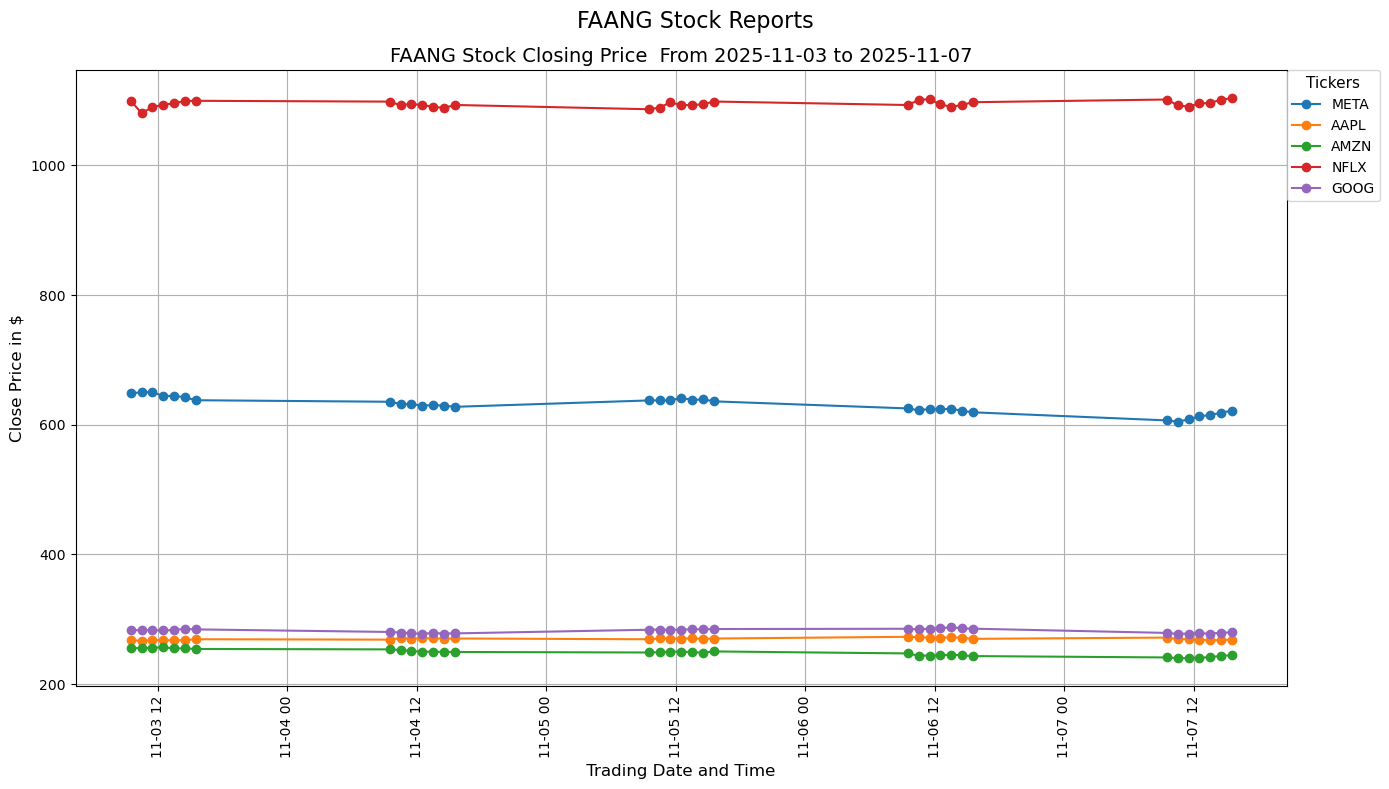

INFO:root:Plot saved to ./plots/20251109_162117.png


✓ Status: 0, Message: Plotting - Return Code: 0, Message: Success, File: ./plots/20251109_162117.png, File: Success


In [122]:
print("Smoke Test : Plotting")
return_code,return_message,filename = plot_data(show_plot=True)
print_status(return_code, f"Plotting - Return Code: {return_code}, Message: {return_message}, File: {filename}", return_message)
